# Batch BO with BoTorch

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qLogExpectedImprovement 
from botorch.optim import optimize_acqf
from utils import gaussian_helper
import importlib



c:\GITHUB\BO-Coli\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using font family: Brisbane Trial


## Function: $f(x) = x \sin(x)$

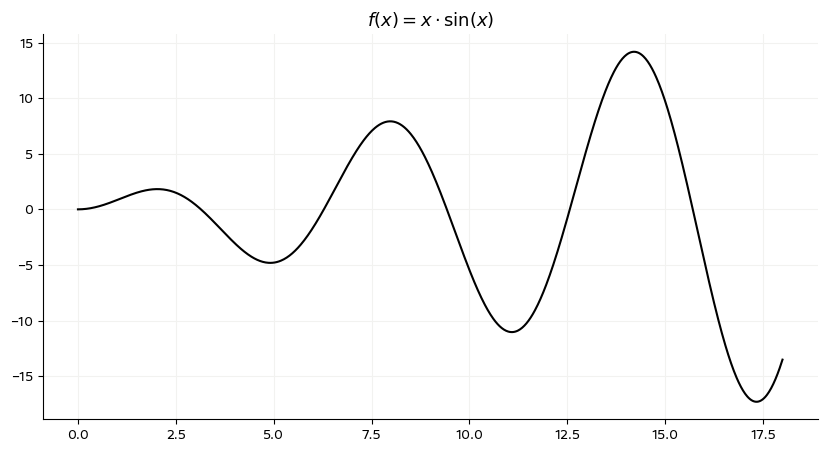

In [2]:
def target_function(x):
    return x * torch.sin(x)


X = np.linspace(0, 18, 1000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

plt.figure(figsize=(10, 5))
plt.plot(X, y, 'k-')
plt.title("$f(x) = x \\cdot \\sin(x)$")
plt.show()

## Setup

In [3]:
n_init, batch_size, n_batches = 4, 4, 4
bounds = torch.tensor([[0.0], [18.0]])
torch.manual_seed(42)
train_x = torch.rand(n_init, 1).double() * bounds[1]
train_y = target_function(train_x)

## Optimization

c:\GITHUB\BO-Coli\.venv\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
c:\GITHUB\BO-Coli\.venv\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


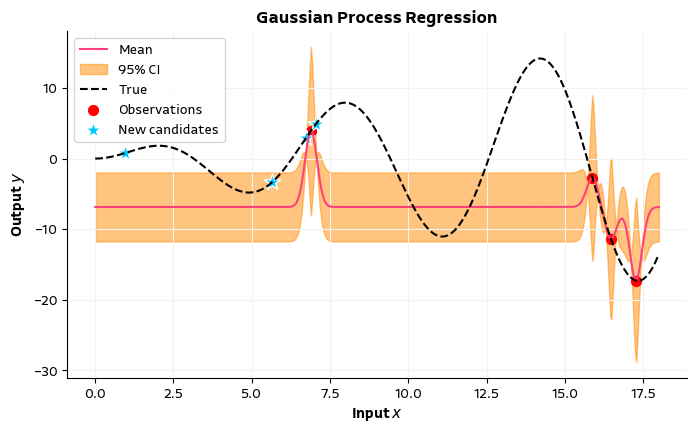

c:\GITHUB\BO-Coli\.venv\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


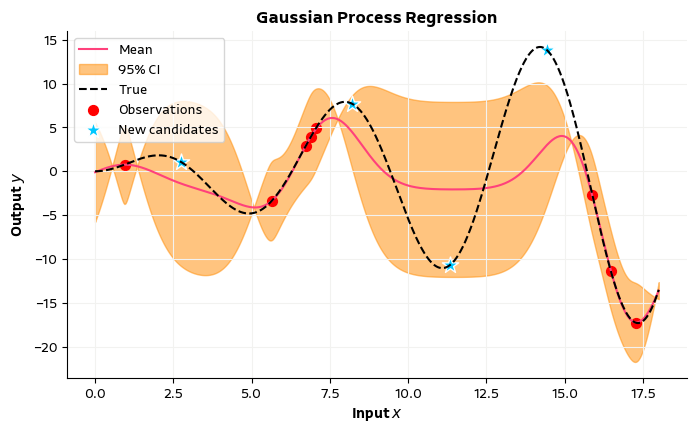

c:\GITHUB\BO-Coli\.venv\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


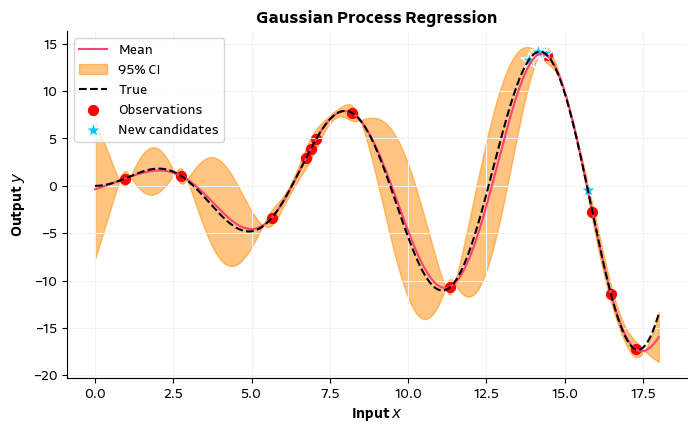

c:\GITHUB\BO-Coli\.venv\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


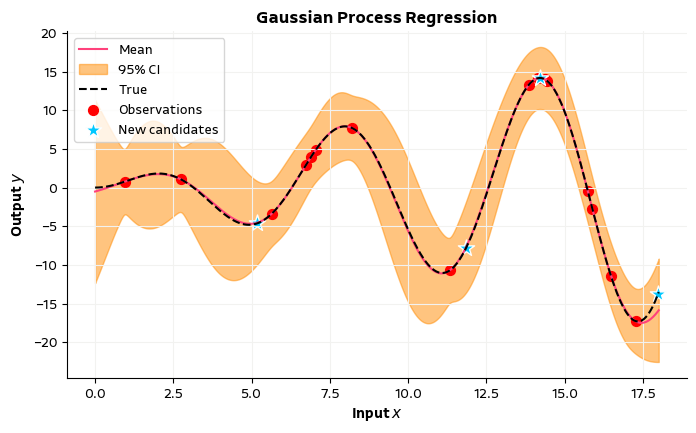

In [ ]:

importlib.reload(gaussian_helper)

model = SingleTaskGP(train_x, train_y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


for i in range(n_batches):

    model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    # Batch acquisition
    acq = qLogExpectedImprovement(model=model, best_f=train_y.max())
    candidates, _ = optimize_acqf(acq_function=acq, bounds=bounds, q=batch_size, 
                                num_restarts=10, raw_samples=512)
    
    # Evaluate
    new_y = target_function(candidates)
    plt.figure(figsize=(8, 4.5))
    gaussian_helper.plot_gp_botorch(model, train_x, train_y, bounds, candidates, new_y, X ,y)
    plt.title("Gaussian Process for Batch BO")
    plt.show()
    
    # Update data
    train_x = torch.cat([train_x, candidates])
    train_y = torch.cat([train_y, new_y])
